# EOmaps Workshop GeoPython 2024
<font size=3>Interactive geo-data analysis with EOmaps and the scientific python infrastructure.</font>

In [1]:
from pathlib import Path
from functools import lru_cache # to cache already loaded timeseries

import pandas as pd
import xarray as xar
from matplotlib.dates import ConciseDateFormatter  # to get nice datetime ticks

from eomaps import Maps, widgets

In [2]:
%matplotlib qt
Maps.config(always_on_top=True)      # keep figures "always on top"

# Spatio-temporal data analysis

In this example, we will explore how we can analyze a whole stack of images with [EOmaps][eomaps].


[eomaps]: https://eomaps.readthedocs.io/


In [3]:
files = list(Path("gridded_data").iterdir()) # a list of all file paths

Let's have a quick look at one of the files:

In [4]:
with xar.open_dataset(files[0]) as ncfile:
    display(ncfile)

<xarray.Dataset> Size: 441MB
Dimensions:    (lat: 1800, lon: 3600, time: 1)
Coordinates:
  * lat        (lat) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon        (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.7 179.8 179.9
  * time       (time) datetime64[ns] 8B 2023-06-01T12:00:00
Data variables: (12/18)
    crs        |S1 1B ...
    SWI_005    (time, lat, lon) float32 26MB ...
    SWI_010    (time, lat, lon) float32 26MB ...
    SWI_001    (time, lat, lon) float32 26MB ...
    SWI_015    (time, lat, lon) float32 26MB ...
    SWI_100    (time, lat, lon) float32 26MB ...
    ...         ...
    QFLAG_100  (time, lat, lon) float32 26MB ...
    QFLAG_020  (time, lat, lon) float32 26MB ...
    QFLAG_005  (time, lat, lon) float32 26MB ...
    QFLAG_001  (time, lat, lon) float32 26MB ...
    QFLAG_060  (time, lat, lon) float32 26MB ...
    SSF        (time, lat, lon) float32 26MB ...
Attributes: (12/25)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2023
    geospatial_lat_max:   89.95
    geospatial_lat_min:   -89.95
    geospatial_lon_max:   179.95
    ...                   ...
    region_name:          GLOBE
    sensor:               ASCAT
    source:               Derived from EO microwave scatterometer observations
    time_coverage_end:    2023-06-01T12:00:00Z
    time_coverage_start:  2023-05-31T12:00:00Z
    title:                Daily Soil Water Index 0.1degree: GLOBE 2023-06-01T...

## Setup functions to load data

Define a function to load a timeseries based on a given (flat) index.

We will use this function in a [**custom callback**][callbacks] to extract timeseries if we click on the map.

[callbacks]: https://eomaps.readthedocs.io/en/latest/api_callbacks.html#custom-callbacks

In [5]:
@lru_cache
def get_ts(ID, parameter):
    data = {}
    for filepath in files:
        with xar.open_dataset(filepath) as ncfile:
            data[ncfile.time.values[0]] = ncfile[parameter].item(ID)
            
    return pd.DataFrame.from_dict(data, orient="index", columns=[parameter])

In [6]:
df = get_ts(1618422, "SWI_010")
df.head()

,SWI_010
2023-06-01 12:00:00,54.5
2023-06-02 12:00:00,55.0
2023-06-03 12:00:00,55.0
2023-06-04 12:00:00,57.0
2023-06-05 12:00:00,57.0


Create a [**custom callback**][callbacks] to plot the timeseries.

The general call-signature for callbacks is:

```python
def some_callback(ID, pos, val, ind, **custom_kwargs):
    # ID:   The ID of the clicked pixel (if available else same as "ind")
    # pos:  The position (x, y) of the clicked pixel (in plot crs)
    # val:  The value of the clicked pixel
    # ind:  The numerical index of the pixel in the flattened data array
```

[callbacks]: https://eomaps.readthedocs.io/en/latest/api_callbacks.html#custom-callbacks

In [7]:
def print_ts(ID, val, m, ax, parameter, time, **kwargs):
    df = get_ts(ID, parameter=parameter)             # load the timeseries
    a, = ax.plot(df, c="k")                          # plot the timeseries
    marker, = ax.plot(time, val, marker="o", c="r")  # add a marker to indicate the current day
    
    m.cb.pick.add_temporary_artist(a)                # remove the timeseries on next pick
    m.cb.pick.add_temporary_artist(marker)           # remote the marker on next pick
    m.redraw()                                       # redraw the figure (optional, only here to avoid glitches in Jupyter Notebooks) 

Define a function to [**lazily add data layers**][on_layer_activation] to a map

The general call-signature for a layer-activation callback is:

```python
def some_callback(m, **custom_kwargs):
    # m:   The Maps object of the layer
```

[on_layer_activation]: https://eomaps.readthedocs.io/en/latest/generated/eomaps.eomaps.Maps.on_layer_activation.html#eomaps.eomaps.Maps.on_layer_activation

In [8]:
# a function that will be executed if the layer becomes visible
def on_layer(m, ax, filepath, parameter):
    with xar.open_dataset(filepath) as ncfile:
        data = ncfile.isel(time=0)[parameter]
        
        m.set_data(data, "lon", "lat", parameter=parameter, crs=ncfile.crs.spatial_ref)
        m.set_shape.shade_raster()
        m.plot_map(set_extent=False)
        
    m.cb.pick.set_execute_on_all_layers(True)                                      # execute callbacks irrespective of the visible layer
    m.cb.pick.attach.annotate()                                                    # add a basic annotation on pick
    m.cb.pick.attach(print_ts, m=m, ax=ax, parameter=parameter, time=ncfile.time)  # run the custom callback on pick

## Visualize the data

In [9]:
m = Maps(layer="all")
m.add_feature.preset("ocean", "land")
m.set_extent((-0.6416666666666515, 30.15833333333336, 32.25, 50.85833333333335))

Since we want to plot timeseries as well, we add an ordinary [matplotlib][mpl] axes to the plot.

[mpl]: https://matplotlib.org/

In [10]:
ax = m.f.add_subplot(211)
ax.xaxis.set_major_formatter(ConciseDateFormatter(ax.xaxis.get_major_locator()))

Re-position the axes with respect to a given layout.
- Make sure to checkout the [**LaouytEditor**][layouteditor] (you can activate it by pressing `alt  + L`)!

[layouteditor]: https://eomaps.readthedocs.io/en/latest/api_layout_editor.html

In [11]:
layout = {
    "figsize": [6.4, 4.8],
    "0_map": [0.10129, 0.35, 0.78621, 0.63333],
    "1_": [0.075, 0.08333, 0.8625, 0.25],
}
m.apply_layout(layout)

**Lazily** add all availalble datasets to the map

In [12]:
for filepath in files:
    m.on_layer_activation(on_layer, layer=filepath.stem, ax=ax, filepath=filepath, parameter="SWI_001")

Show the first layer

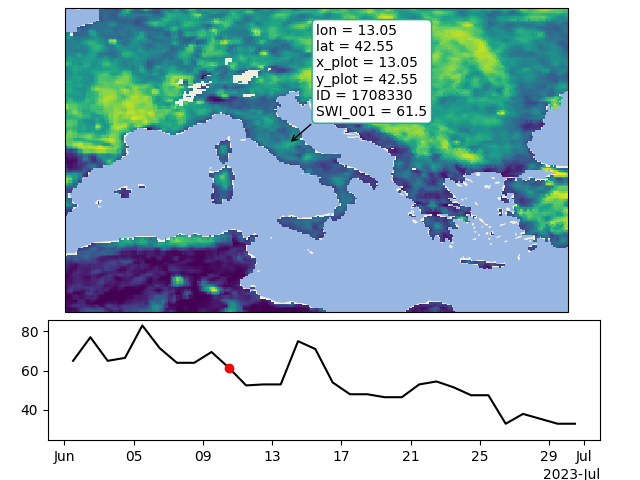

In [16]:
m.show_layer(files[0].stem)
m.show()

Get a slider to switch layers

In [14]:
widgets.LayerSelectionSlider(m, layers=[i.stem for i in files], layout=dict(width='500px'))

LayerSelectionSlider(description='Layers', layout=Layout(width='500px'), options=(('c_gls_SWI_202306011200_GLO…

In [15]:
m.fetch_layers()

# [$\Rightarrow$ Irregularly sampled data](<03 Spatiotemporal_analysis.ipynb>)